#### Libraries used 

In [1]:
import numpy as np     

import plotly.offline as offline       # a number of plotly goodies
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

import matplotlib as mlab
import matplotlib.pyplot as plt        # some matplotlib for good measure
from matplotlib.colors import LogNorm

import scipy.stats as st               # and scipy in case everything else fails
from scipy import interpolate
from scipy.interpolate import griddata

#### EMMC output data

### 10k electrons incident on a Si sample tilted by 70 degrees

In [2]:
fileName = 'singlerun10k.txt'

#### Initialise arrays

In [3]:
el = -1        #electon identifier
step = 0       #step number
energy = []    #energy array of electron el
energy.append([])
xyz = []       # xyz positions array for electron el
xyz.append([])
cxyz = []      # directional cosines array for electron el
cxyz.append([])

#### Read and clasify the data

In [4]:
with open(fileName, "r") as data:
    for line in data: #read one line at a time
        column = line.replace(':',' ').replace(',',' ').split()


        if column[0] is '0': #reinitialise and update
            energy.append([])
            cxyz.append([])
            xyz.append([])

            el = el + 1

        energy[el].append(float(column[1]))
        cxyz[el].append([ float(column[2]), float(column[3]), float(column[4]) ])
        xyz[el].append([ float(column[5]), float(column[6]), float(column[7]) ])

In [5]:
TSE2 = 0

zmax = -200   # in nanometers

t_energy = [] #energy array of transmitted electron el
t_energy.append([])
t_xyz = []    #xyz position array for transmitted electron el
t_xyz.append([])
t_cxyz = []   #directional cosines array for transmitted electron el
t_cxyz.append([])

for i in range(el+1):

    zs = [positions[2] for positions in xyz[i] ] # z values

    if any( z < zmax for z in zs ): #transmitted
        #find index of last event before exit
        indexin = np.where(np.array(zs)<zmax)
        last_event = indexin[0][0]

        t_energy[TSE2] = energy[i][0:last_event]
        t_cxyz[TSE2] = cxyz[i][0:last_event]
        t_xyz[TSE2] = xyz[i][0:last_event]

        TSE2 = TSE2 + 1
        t_energy.append([])
        t_xyz.append([])
        t_cxyz.append([])
        
print "number of transmitted electrons: ", TSE2        

number of transmitted electrons:  9797


In [6]:
t_xs = [] # list of transmitted electrons x positions
t_zs = []
for traj in t_xyz:
    for event in traj:
        t_xs.append(event[0])
        t_zs.append(event[2])

t_energy_ar = np.array([item for sublist in t_energy for item in sublist])
t_xs_ar = np.array(t_xs)
t_zs_ar = np.array(t_zs)

#### KDE colours:

In [7]:
purples=[[0.0,   '#fcf9f7'],
 [0.1666666666666666, '#edcfc9'],
 [0.3333333333333333, '#daa2ac'],
 [0.5,                '#bc7897'],
 [0.6666666666666666, '#925684'],
 [0.8333333333333333, '#5f3868'],
 [1.0,                '#2d1e3e']]

x1, x2 = (0, 1000)
y1, y2 = (zmax, 0)

### KDE plot function:

In [8]:
def kde_scipy( vals1, vals2, (a,b), (c,d), N, bw ):

    #vals1, vals2 are the values of two variables (columns)
    #(a,b) interval for vals1; usually larger than (np.min(vals1), np.max(vals1))
    #(c,d) -"-          vals2

    x = np.linspace(a,b,N)
    y = np.linspace(c,d,N)
    X,Y = np.meshgrid(x,y)
    positions = np.vstack([Y.ravel(), X.ravel()])

    values = np.vstack([vals1, vals2])
    kernel = st.gaussian_kde(values, bw_method = bw)
    Z = np.reshape(kernel(positions).T, X.shape)

    return [x, y, Z]

def make_kdedata(varX, varY, (a,b), (c,d), N, bw, colorsc):
    #varX, varY are lists, 1d numpy.array(s), or dataframe columns, storing the values of two variables

    x, y, Z = kde_scipy(varY, varX, (a,b), (c,d), N, bw )

    data = go.Data([
       go.Contour(
           z=Z,
           x=x,
           y=y,
           colorscale=colorsc,
           #reversescale=True,
           opacity=0.9,
           contours=go.Contours(
               showlines=False)
        ),
     ])
    
    return data



### Scatter plot function

In [9]:
def make_ScatterTrace(varX, varY, weight=None):

    if (weight is not None ):      
        traceScatter = go.Scatter(
                    x = varX,
                    y = varY,
                    mode = 'markers',
                    name = 'events',
                    marker = dict(
                        color='#2d1e3e',
                        size = weight,
                        opacity=0.4
                    )
                )
    else :   
        traceScatter = go.Scatter(
                    x = varX,
                    y = varY,
                    mode = 'markers',
                    name = 'events',
                    marker = dict(
                    color='#2d1e3e',
                    size = 2,
                    opacity=0.4
                    )
                )     
                
    return traceScatter

### Side histogram for depth distribution function 

In [10]:
def make_sideHistogram(varY):
    traceHside = go.Histogram(
        y = varY,
        name = 'events',
        histnorm = 'probability',
        autobinx = True,
        #ybins = dict(
        #        start=zmax,
        #        end=0,
        #        size=50
        #    ),
        marker = dict(color='#2d1e3e'),
        xaxis = 'x2'
    )
    return traceHside

#### The layout for scatter + side histogram

In [31]:
layoutSandH = go.Layout(
    showlegend=False,
    autosize=False,
    width=880,
    height=300,

    xaxis=dict(go.XAxis(range=[x1, x2]),
               domain=[0, 0.81],
               nticks=5,
               showgrid=False,
               zeroline=False,
               title='x Axis (nm)',
               titlefont=dict(
               family='Courier New, monospace',
               size=20,
               color='#7f7f7f')
        ),
    yaxis=dict(go.YAxis(range=[y1,y2]),
               domain=[0, 1],
               nticks=5,
               showgrid=False,
               zeroline=False,
               title='z Axis (nm)',
               titlefont=dict(
               family='Courier New, monospace',
               size=20,
               color='#7f7f7f')
    ),

    margin=dict(
             t=50
    ),

    hovermode='closest',
    bargap=0,
    xaxis2=dict(
        domain=[0.85, 1],
        showgrid=False,
        zeroline=False
    ),
    #title='Elastic events scatter plot',
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

#### Uniform or nonuniform sampling

In [12]:
def uniform_sample(nu, au):
    # numpy.random.choice(a, size=size, replace=True, p=None)
    return np.random.choice(au, size=nu, replace=True)



def nonuniform_sample(nn, an, p):
    # numpy.random.choice(a, size=size, replace=True, p=p)
    return np.random.choice(an, size=nn, replace=True, p=p)

### Create a small, fast plottable sample from all the postions of electrons

In [13]:
num = 5000
# sample from the indexes
sample_idxs = uniform_sample(num,len(t_xs_ar))

t_sample_xs = t_xs_ar[sample_idxs]
t_sample_zs = t_zs_ar[sample_idxs]
t_sample_energy = t_energy_ar[sample_idxs]


#### Show the scatter plot for a 5000 elastic events sample

In [15]:
traceScatter = make_ScatterTrace(t_sample_xs, t_sample_zs)
traceHside = make_sideHistogram(t_sample_zs)
dataToPlot = [traceScatter]
figSandH = go.Figure(data=dataToPlot, layout=layoutSandH)
#py.iplot(figSandH)
py.image.save_as(figSandH, filename='scatter.pdf')

#### A closer look at the depth distribution

In [16]:
figDepth = ff.create_distplot([ t_sample_zs], ['depth density'],  bin_size=10 )
py.iplot(figDepth, filename = 'Transmitted electrons unweighted  Depth Distribution ' )

#### Show the KDE plot

In [19]:
N = 200 # point to sample on a mesh for the KDE
bw = 0.2 # bandwidth
KDEdata = make_kdedata(t_sample_xs, t_sample_zs, (x1, x2), (y1, y2), N, bw, purples)

layoutKDE =  go.Layout(xaxis = dict(title = 'X axis (nm)'), 
                    yaxis = dict(title = 'Z axis (nm)'),
                    autosize=False,
                    width=880,
                    height=450,   
                    showlegend=False,
                    #title = 'Uniformly sampled KDE'
                      )
figureKDE = go.Figure(data=KDEdata, layout= layoutKDE)

py.iplot(figureKDE)
#py.image.save_as(figureKDE, filename='KDE.pdf')

#### What if we treat the spatial distribution as a probability distribution function

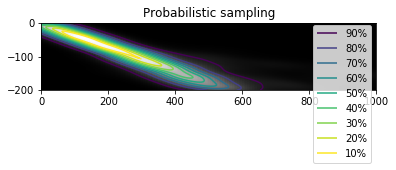

In [20]:
xKDE, yKDE, ZKDE = kde_scipy(t_sample_zs, t_sample_xs, (x1,x2), (y1,y2), N, bw )
ZKDE = ZKDE / ZKDE.sum()

n = 100
t = np.linspace(0, ZKDE.max(), n)
integral = ((ZKDE >= t[:, None, None]) * ZKDE).sum(axis=(1,2))



f = interpolate.interp1d(integral, t)
t_contours = f(np.array([0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]))
plt.imshow(ZKDE, origin='lower', extent=[x1, x2, y1, y2], cmap="gray")
CS = plt.contour(ZKDE, t_contours, extent=[x1, x2, y1, y2])

labels = ['90%', '80%','70%','60%', '50%', '40%', '30%', '20%', '10%']
for i in range(len(labels)):
    CS.collections[i].set_label(labels[i])
    
plt.title('Probabilistic sampling')
plt.legend(bbox_to_anchor=(1.0, 1.05))

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 12
plt.show()

In [21]:
xz_sample = np.array([(a,b) for a, b in zip(*(t_sample_xs, t_sample_zs))])
inCont = np.zeros((9, num))

for line in range(8):
    p = CS.collections[line].get_paths()[0]
    x = p.vertices[:,0]
    z = p.vertices[:,1]
    XZ = np.array([(a,b) for a, b in zip(*(x, z))])

    contour = mlab.path.Path(XZ)
    inCont[line] = contour.contains_points(xz_sample)
    
p_weights = [sum([yesno[point] for yesno in inCont]) for point in range(num)]



sum_pweights = sum(p_weights)
t_weight_p = p_weights/sum_pweights # normalise this array to probabilities

n_p = 5000
Psample_indxs = nonuniform_sample(n_p , len(t_sample_xs), t_weight_p)

t_NUsample_x = t_sample_xs[Psample_indxs]
t_NUsample_z = t_sample_zs[Psample_indxs]
t_NUsample_energy = t_sample_energy[Psample_indxs]




#### The scatter plot looks like

In [22]:
traceScatter = make_ScatterTrace(t_NUsample_x, t_NUsample_z)
traceHside = make_sideHistogram(t_NUsample_z)
dataToPlot = [traceScatter, traceHside]
figSandH = go.Figure(data=dataToPlot, layout=layoutSandH)
py.iplot(figSandH)



#### The depth histogram is:

In [23]:
figDepth = ff.create_distplot([t_NUsample_z], ['depth probability of finding electrons'],  bin_size=10 )
py.iplot(figDepth, filename = 'Frequency of incoherent scattering with depth' )

In [24]:
N = 400 # point to sample on a mesh for the KDE
bw = 0.2 # bandwidth
KDEdata = make_kdedata(t_NUsample_x, t_NUsample_z, (x1, x2), (y1, y2), N, bw, purples)

layoutKDE =  go.Layout(xaxis = dict(title = 'X axis (nm)'), 
                    yaxis = dict(title = 'Z axis (nm)'),
                    title = 'Non-uniformly sampled KDE')
figureKDE = go.Figure(data=KDEdata, layout= layoutKDE)

py.iplot(figureKDE)

## Probability of incohernet scattering at a depth z

In [25]:
lost_energies = 20.-  np.array(t_NUsample_energy)
sum_energies = sum(lost_energies)
t_weight_z = lost_energies/ sum_energies # normalise this array to probabilities

n = 4000
Ssample_indxs = nonuniform_sample(n , len(t_NUsample_z), t_weight_z)

t_Ssample_z = t_NUsample_z[Ssample_indxs]
t_Ssample_x = t_NUsample_x[Ssample_indxs]
t_Ssample_energy = t_NUsample_energy[Ssample_indxs]

point_size = lost_energies[Ssample_indxs] # for scatter plot

In [39]:
traceScatter = make_ScatterTrace(t_Ssample_x, t_Ssample_z,point_size*100 )
traceHside = make_sideHistogram(t_Ssample_z)
dataToPlot = [traceScatter]
figSandH = go.Figure(data=dataToPlot, layout=layoutSandH)
py.iplot(figSandH)
#py.image.save_as(figSandH, filename='incoherent_scatter.png')

In [40]:
figDepth = ff.create_distplot([t_Ssample_z], ['depth probability of incoherent scattering'],  bin_size=10 )
py.iplot(figDepth, filename = 'Frequency of incoherent scattering with depth' )

In [41]:
N = 400 # point to sample on a mesh for the KDE
bw = 0.2 # bandwidth
KDEdata = make_kdedata(t_Ssample_x, t_Ssample_z, (x1, x2), (y1, y2), N, bw, purples)

layoutKDE =  go.Layout(xaxis = dict(title = 'X axis (nm)'), 
                    yaxis = dict(title = 'Z axis (nm)'),
                    title = 'Non-uniformly sampled KDE')
figureKDE = go.Figure(data=KDEdata, layout= layoutKDE)

py.iplot(figureKDE)

## Probability for an incoherent electron to reach the detector

In [42]:
# let zmax be sample thickness
t_escape= np.exp((zmax-t_Ssample_z)*2./-zmax)
sum_escape = sum(t_escape)
t_weight_escape = t_escape/ sum_escape # normalise this array to probabilities


n = 5000
Isample_indxs = nonuniform_sample(n, len(t_Ssample_z), t_weight_escape)

t_Isample_z = t_Ssample_z[Isample_indxs]
t_Isample_x = t_Ssample_x[Isample_indxs]
t_Isample_energy = t_Ssample_energy[Isample_indxs]


In [43]:
traceScatter = make_ScatterTrace(t_Isample_z, t_weight_escape[Isample_indxs])

dataToPlot = [traceScatter]

layout = go.Layout(
    xaxis=dict(
        title='Z axis', 
        #range = [-6000, 0]
    ),
    yaxis=dict(
        title='Escape probability weight',          
        #range = [0, 0.0004]

    ))

figSandH = go.Figure(data=dataToPlot, layout=layout)
py.iplot(figSandH)

In [44]:
figDepth = ff.create_distplot([t_Isample_z], ['escaped electrons depth'], bin_size= 10 )
py.iplot(figDepth, filename = 'Depth distribution of information' )

In [45]:
figEnergy = ff.create_distplot([t_Isample_energy], ['escaped electrons energy'], bin_size= 0.01)
py.iplot(figEnergy, filename = 'Energy distribution of information' )

In [50]:
N = 400 # point to sample on a mesh for the KDE
bw = 0.2 # bandwidth
KDEdata = make_kdedata(t_Isample_x, t_Isample_z, (x1, x2), (y1, y2), N, bw, purples)

layoutKDE =  go.Layout(xaxis = dict(title = 'X axis (nm)'), 
                    yaxis = dict(title = 'Z axis (nm)'),
                    title = 'Non-uniformly sampled KDE')
figureKDE = go.Figure(data=KDEdata, layout= layoutKDE)

py.iplot(figureKDE)
#py.image.save_as(figureKDE, filename='totalweigh_scatter.pdf')